In [248]:
%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression, GradientDescentOptimizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Introduction

Recently, we introduced the gradient descent algorithm for solving the empirical risk minimization problem. We also calculated the gradient of the loss function for logistic regression.

In this blog post you will:

Implement gradient descent for logistic regression in an object-oriented paradigm.
Implement a key variant of gradient descent with momentum in order to achieve faster convergence.
Perform experiments to test your implementations.

# Part A: Implement Logistic Regression

## Implement ``LinearModel`` and ``LogisticRegression()``
If you haven’t already, implement the methods of the ``LinearModel`` class as described in this warmup. Then, define a new class called ``LogisticRegression`` which inherits from ``LinearModel``. This class should have two methods:

- ``LogisticRegression.loss(X, y)`` should compute the empirical risk $L(w)$ using the logistic loss function. The weight vector ``w`` used for this calculation should be stored as an instance variable of the class.

- ``LogisticRegression.grad(X, y)`` should compute the gradient of the empirical risk $L(w)$. You can use the formula for the gradient supplied in the lecture notes on gradient descent.

For an **M**, you can implement ``LogisticRegression.grad`` using a ``for``-loop. For an **E**, your solution should involve no explicit loops. While working on a solution that avoids loops, you might find it useful to at some point convert a tensor ``v`` with shape ``(n,)`` into a tensor ``v_`` with shape ``(n,1)``. The code ``v_ = v[:, None]`` will perform this conversion for you.

## Implement ``GradientDescentOptimizer``

Next, implement a ``GradientDescentOptimizer`` class. For this project, we are going to implement _gradient descent with momentum_, also known as Spicy Gradient Descent. Let w~k~ be the estimate of the weight vector at algorithmic step k. Gradient descent with momentum performs the update equation.

# Part B: Experiments

## Experimental Data

## How to Train Your Model

## Experiments

# Part C: Writing

In [249]:
""" 
logistic.py

implements 
- LinearModel
- LogisticRegression which inherits from LinearModel

"""

import torch

class LinearModel:

    def __init__(self):
        self.w = None 

    def score(self, X):
        """
        Compute the scores for each data point in the feature matrix X. 
        The formula for the ith entry of s is s[i] = <self.w, x[i]>. 

        ARGUMENTS: 
            X, torch.Tensor: the feature matrix. X.size() == (n, p), 
            where n is the number of data points and p is the 
            number of features. This implementation always assumes 
            that the final column of X is a constant column of 1s. 

        RETURNS: 
            s torch.Tensor: vector of scores. s.size() = (n,)

        If self.w currently has value None, then it is necessary to first initialize self.w to a random value. 
        """
        if self.w is None: 
            self.w = torch.rand((X.size()[1]))
        
        return X@self.w

    def predict(self, X):

        """
        Compute the predictions for each data point in the feature matrix X. 
        The prediction for the ith data point is either 0 or 1. 

        ARGUMENTS: 
            X, torch.Tensor: the feature matrix. X.size() == (n, p), 
            where n is the number of data points and p is the 
            number of features. This implementation always assumes 
            that the final column of X is a constant column of 1s. 

        RETURNS: 
            y_hat, torch.Tensor: vector predictions in {0.0, 1.0}. y_hat.size() = (n,)
        """
        s = self.score(X)
        return (s > 0).int()
        
        pass 



class LogisticRegression(LinearModel):
    
    def loss(self, X, y):

        """
        Computes the empirical risk L(w) using the logistic loss function

        ARGUMENTS:
            X, torch.Tensor: the feature matrix. X.size() == (n, p),
            where n is the number of data points and p is the 
            number of features. This implementation always assumes
            that the final column of X is a constant column of 1s.

            y, torch.Tensor: the target vector. y.size() = (n,). 
            The Possible labels for y are {0, 1}

        RETURNS:
            the empirical risk L(w)
            equation:
            mean[-yi log(sigmoid(si)) - (1-yi)log(1-sigmoid(si))]
        """

        self.score(X)                   # call our score function to get the weights w
        scores = X @ self.w             # get our score vector s to use in the logistic loss function
        def sigmoid(z):                 # implementation of sigmoid function
            return 1/(1 + torch.exp(-z))

        # use the logistic loss function to calculate L(w)!
        loss = torch.mean(-y * torch.log(sigmoid(scores)) - (1 - y) * torch.log(1 - sigmoid(scores)))
        return loss
    

    def grad(self, X, y):
        
        """
        Computes the gradient of the empirical risk L(w)

        ARGUMENTS: 
            X, torch.Tensor: the feature matrix. X.size() == (n, p),
            where n is the number of data points and p is the 
            number of features. This implementation always assumes 
            that the final column of X is a constant column of 1s. 

            y, torch.Tensor: the target vector. y.size() == (n,).
            The possible labels for y are {0, 1}

        RETURNS:
            the gradient of the empirical risk L(w)
            equation:
            change of L(w) = mean(sigmoid(si) - yi)xi
            
        """

        y_ = y[:, None]                 # convert tensor with shape (n,) to shape (n,1)

        self.score(X)                   # call our score function to get the weights w
        scores = X @ self.w             # get our score vector s to use in the logistic loss function
        scores = scores[:, None]
        def sigmoid(z):                 # implementation of sigmoid function
            return 1/(1 + torch.exp(-z))
        
        #print(y_.shape)
        #print((sigmoid(scores) - y_).shape)
        #print(X.shape)
        
        gradients = (sigmoid(scores) - y_) * X
        gradient = torch.mean(gradients, dim=0)
        return gradient



class GradientDescentOptimizer():

    def __init__(self, model):
        self.model = model
        self.w_old = None

    def step(self, X, y, alpha, beta):

        """
        Implements Gradient Descent with Momentum
        It performs an update of the weights w

        ARGUMENTS:
            X, torch.Tensor: the feature matrix

            y, torch.Tensor: the target vector

            alpha

            beta

        RETURNS:
            Nothing
            Updates the weights self.model.w
            Use equation:
            Wk+1 <-- Wk - alpha(grad(Wk)) + beta(Wk - Wk+1)
        """

        gradient = self.model.grad(X, y)
        w = self.model.w
        #if self.w_old is None:
            #self.w_old = torch.zeros_like(w)

        new_weights = w - alpha*gradient

        if self.w_old != None:
            new_weights += beta*(w - self.w_old)
        
        #new_weights = w - alpha*gradient + beta*(w - self.w_old)
        self.w_old = w.clone()
        self.model.w = new_weights
        print(new_weights)
        

        


# TESTING
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X, y = classification_data(noise = 0.5)

LR = LogisticRegression()
opt = GradientDescentOptimizer(LR)
s = LR.loss(X, y)
g = LR.grad(X, y)
print(s)
print(g)




tensor(0.4734)
tensor([-0.0369, -0.0554,  0.1729])


tensor([0.0904, 0.1831, 1.7245])
tensor([0.1414, 0.2763, 2.4127])
tensor([0.1904, 0.3658, 2.9891])
tensor([0.2365, 0.4506, 3.4619])
tensor([0.2793, 0.5308, 3.8398])
tensor([0.3189, 0.6065, 4.1315])
tensor([0.3556, 0.6783, 4.3453])
tensor([0.3896, 0.7463, 4.4887])
tensor([0.4210, 0.8110, 4.5686])
tensor([0.4501, 0.8725, 4.5913])
tensor([0.4772, 0.9313, 4.5625])
tensor([0.5024, 0.9876, 4.4874])
tensor([0.5258, 1.0416, 4.3706])
tensor([0.5477, 1.0935, 4.2165])
tensor([0.5681, 1.1435, 4.0289])
tensor([0.5873, 1.1916, 3.8114])
tensor([0.6052, 1.2381, 3.5674])
tensor([0.6219, 1.2829, 3.2999])
tensor([0.6376, 1.3260, 3.0120])
tensor([0.6522, 1.3675, 2.7066])
tensor([0.6656, 1.4072, 2.3866])
tensor([0.6780, 1.4449, 2.0552])
tensor([0.6892, 1.4804, 1.7155])
tensor([0.6993, 1.5135, 1.3712])
tensor([0.7083, 1.5441, 1.0258])
tensor([0.7165, 1.5720, 0.6834])
tensor([0.7243, 1.5976, 0.3478])
tensor([0.7324, 1.6211, 0.0231])
tensor([ 0.7416,  1.6433, -0.2872])
tensor([ 0.7531,  1.6653, -0.5799])
tens

tensor([ 1.3217,  2.2024, -2.3292])
tensor([ 1.3991,  2.2700, -2.3534])
tensor([ 1.4771,  2.3380, -2.3676])
tensor([ 1.5546,  2.4054, -2.3736])
tensor([ 1.6308,  2.4715, -2.3732])
tensor([ 1.7050,  2.5356, -2.3679])
tensor([ 1.7765,  2.5974, -2.3593])
tensor([ 1.8449,  2.6563, -2.3484])
tensor([ 1.9098,  2.7120, -2.3363])
tensor([ 1.9711,  2.7644, -2.3238])
tensor([ 2.0284,  2.8133, -2.3118])
tensor([ 2.0819,  2.8587, -2.3006])
tensor([ 2.1314,  2.9006, -2.2909])
tensor([ 2.1770,  2.9390, -2.2828])
tensor([ 2.2188,  2.9740, -2.2767])
tensor([ 2.2569,  3.0057, -2.2727])
tensor([ 2.2915,  3.0342, -2.2709])
tensor([ 2.3227,  3.0599, -2.2714])
tensor([ 2.3508,  3.0826, -2.2740])
tensor([ 2.3758,  3.1028, -2.2787])
tensor([ 2.3981,  3.1205, -2.2855])
tensor([ 2.4178,  3.1360, -2.2942])
tensor([ 2.4352,  3.1494, -2.3046])
tensor([ 2.4503,  3.1608, -2.3167])
tensor([ 2.4635,  3.1706, -2.3302])
tensor([ 2.4748,  3.1788, -2.3450])
tensor([ 2.4845,  3.1856, -2.3608])
tensor([ 2.4928,  3.1912, -2

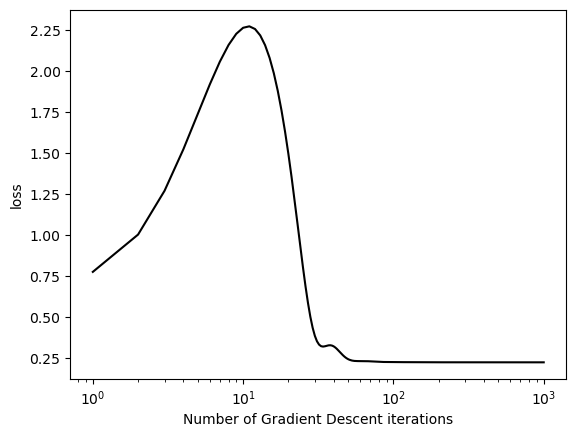

In [250]:
# TRAIN the model
from matplotlib import pyplot as plt

LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

loss_vec = []

for _ in range(1000):
    # add other stuff to e.g. keep track of the loss over time. 

    loss = LR.loss(X, y)
    loss_vec.append(loss)

    opt.step(X, y, alpha = 0.1, beta = 0.9)

plt.plot(torch.arange(1, len(loss_vec) +1), loss_vec, color="black")
plt.semilogx()
labs = plt.gca().set(xlabel = "Number of Gradient Descent iterations", ylabel="loss")